#OME Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/2022OME'
%pwd

/content/drive/MyDrive/2022OME


'/content/drive/MyDrive/2022OME'

In [3]:
num = 37

In [16]:
print(f"block{num}")
config = {
    "n_epochs":100,
    "patience":40,
    "learning_rate":0.0003,
    "weight_decay":1e-6,
    "target":f"/block{num}"
    #block46, 47 skipped
}

block37


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 12 15:44:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Training

In [5]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset, random_split, SubsetRandomSampler
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random
import time

In [6]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## **Transforms**
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [7]:
from torchvision.transforms.transforms import CenterCrop
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((180, 180)),
    # You may add some transforms here.
    transforms.ColorJitter(0.5, 0.8, 0.5, 0),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomRotation(60),
    transforms.RandomPerspective(0.3),
    transforms.RandomCrop((128, 128)),
    # transforms.GaussianBlur(3),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])


## **Datasets**
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [8]:
class ImageDataset(Dataset):
    def __init__(self,path,tfm=test_tfm,files = None):
        super(ImageDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        print(self.files)
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        # im_std, im_mean = torch.std_mean(im)
        # im = im - im_mean
        # print(im)
        
        # im = self.data[idx]
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        # print(label)
        return im,label



# Model Architecture

In [9]:
import torchvision.models as model_set

resnet18 = model_set.resnet18(pretrained = False)
resnet18.fc = nn.Linear(in_features= resnet18.fc.in_features, out_features = 2)
# resnet18.fc = nn.Sequential(
#     nn.Linear(in_features= resnet18.fc.in_features, out_features = resnet18.fc.out_features),
#     nn.ReLU(),
#     nn.Linear(in_features= resnet18.fc.out_features, out_features = 2)
# )

# print(resnet18) 

pre_resnet18 = model_set.resnet18(pretrained = True)
pre_resnet18.fc = nn.Linear(in_features = pre_resnet18.fc.in_features, out_features = 2)
# print(pre_resnet18)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/to

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]

            nn.Dropout(0.5)
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 256),
            # nn.ReLU(),
            # nn.Linear(4096, 1024),
            # nn.ReLU(),
            # nn.Linear(1024, 2),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
    def forward(self, x):
        # print(x.shape)
        out = self.cnn(x)
        # print(out.shape)
        # out = AdaptiveAvgPool2d(output_size=(1, 1))
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [11]:
def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return train_set, valid_set
seed = 19981003

In [12]:
# "cuda" only when GPUs are available.
device =  "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
batch_size = 5
_dataset_dir = "./imgs_2nd"
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
img_set_ = ImageDataset(os.path.join(_dataset_dir, config["target"][1:]+"/training"), tfm=train_tfm )
print(len(img_set_))
train_set, valid_set = train_valid_split(img_set_, 0.1, seed)

valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

['./imgs_2nd/block37/training/0_1.jpg', './imgs_2nd/block37/training/0_10.jpg', './imgs_2nd/block37/training/0_100.jpg', './imgs_2nd/block37/training/0_101.jpg', './imgs_2nd/block37/training/0_102.jpg', './imgs_2nd/block37/training/0_103.jpg', './imgs_2nd/block37/training/0_104.jpg', './imgs_2nd/block37/training/0_105.jpg', './imgs_2nd/block37/training/0_106.jpg', './imgs_2nd/block37/training/0_107.jpg', './imgs_2nd/block37/training/0_108.jpg', './imgs_2nd/block37/training/0_109.jpg', './imgs_2nd/block37/training/0_11.jpg', './imgs_2nd/block37/training/0_110.jpg', './imgs_2nd/block37/training/0_111.jpg', './imgs_2nd/block37/training/0_112.jpg', './imgs_2nd/block37/training/0_113.jpg', './imgs_2nd/block37/training/0_114.jpg', './imgs_2nd/block37/training/0_115.jpg', './imgs_2nd/block37/training/0_116.jpg', './imgs_2nd/block37/training/0_117.jpg', './imgs_2nd/block37/training/0_118.jpg', './imgs_2nd/block37/training/0_119.jpg', './imgs_2nd/block37/training/0_12.jpg', './imgs_2nd/block37/

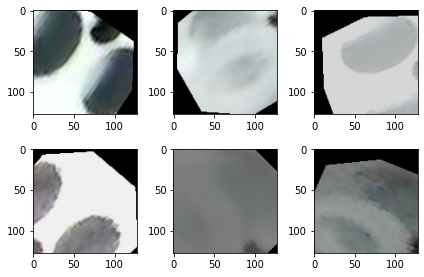

In [18]:
import matplotlib.pyplot as plt

axes = []
fig = plt.figure()
for i in range(6):
  axes.append(fig.add_subplot(2, 3, i+1))
  plt.imshow(train_set[i][0].permute(1, 2, 0))#h, w, c
fig.tight_layout()
plt.show()

In [19]:
# Initialize a model, and put it on the device specified.
sample_model = Classifier().to(device)
# sample_model.load_state_dict(torch.load(f"./best_result{config['target']}/basic_CNN_best.ckpt"))

res18_model = resnet18.to(device)
# res18_model.load_state_dict(torch.load(f"./best_result{config['target']}/resnet18_best.ckpt"))

pre_res18_model = pre_resnet18.to(device)
# pre_res18_model.load_state_dict(torch.load(f"pre_resnet18_best.ckpt"))

#Train

In [20]:
def trainer(train_loader, valid_loader, model, device, name, n_epochs, patience):
  # The number of training epochs and patience.
  # n_epochs = 200
  # patience = 40 # If no improvement in 'patience' epochs, early stop

  # For the classification task, we use cross-entropy as the measurement of performance.
  criterion = nn.CrossEntropyLoss()

  # Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
  optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]) 

  # Initialize trackers, these are not parameters and should not be changed
  stale = 0
  best_acc = 0
  lowest_loss = 1
  # lr scheduler
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

  for epoch in range(n_epochs):

      # ---------- Training ----------
      # Make sure the model is in train mode before training.
      model.train()

      # These are used to record information in training.
      train_loss = []
      train_accs = []

      for batch in tqdm(train_loader):

          # A batch consists of image data and corresponding labels.
          imgs, labels = batch
          #imgs = imgs.half()
          # print(imgs.shape,labels.shape)

          # Forward the data. (Make sure data and model are on the same device.)
          logits = model(imgs.to(device))
          # print(logits)

          # Calculate the cross-entropy loss.
          # We don't need to apply softmax before computing cross-entropy as it is done automatically.
          loss = criterion(logits, labels.to(device))
          # It isn't real logits, it is just log of probability
          # https://www.zhihu.com/question/60751553
          # https://stackoverflow.com/questions/34240703/what-are-logits-what-is-the-difference-between-softmax-and-softmax-cross-entrop

          # Gradients stored in the parameters in the previous step should be cleared out first.
          optimizer.zero_grad()

          # Compute the gradients for parameters.
          loss.backward()

          # Clip the gradient norms for stable training.
          grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

          # Update the parameters with computed gradients.
          optimizer.step()

          # Compute the accuracy for current batch.
          acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

          # Record the loss and accuracy.
          train_loss.append(loss.item())
          train_accs.append(acc)

      scheduler.step()    
      
      train_loss = sum(train_loss) / len(train_loss)
      train_acc = sum(train_accs) / len(train_accs)

      # Print the information.
      print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

      # ---------- Validation ----------
      # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
      model.eval()

      # These are used to record information in validation.
      valid_loss = []
      valid_accs = []

      # Iterate the validation set by batches.
      for batch in tqdm(valid_loader):

          # A batch consists of image data and corresponding labels.
          imgs, labels = batch
          #imgs = imgs.half()

          # We don't need gradient in validation.
          # Using torch.no_grad() accelerates the forward process.
          with torch.no_grad():
              logits = model(imgs.to(device))

          # We can still compute the loss (but not the gradient).
          loss = criterion(logits, labels.to(device))

          # Compute the accuracy for current batch.
          acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

          # Record the loss and accuracy.
          valid_loss.append(loss.item())
          valid_accs.append(acc)
          #break

      # The average loss and accuracy for entire validation set is the average of the recorded values.
      valid_loss = sum(valid_loss) / len(valid_loss)
      valid_acc = sum(valid_accs) / len(valid_accs)

      # Print the information.
      print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


      # update logs
      if valid_acc > best_acc or ((valid_acc == best_acc) and (valid_loss <= lowest_loss)):
          with open(f"./{name}_log.txt","a"):
              print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
          lowest_loss = valid_loss
      else:
          with open(f"./{name}_log.txt","a"):
              print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


      # save models
      if valid_acc > best_acc or ((valid_acc == best_acc) and (valid_loss == lowest_loss)):
          print(f"Best model found at epoch {epoch}, saving model")
          if config['target'][1:] not in os.listdir("./best_result"):
            os.mkdir(f"./best_result{config['target']}")
          torch.save(model.state_dict(), f"./best_result{config['target']}/{name}_best.ckpt") # only save best to prevent output memory exceed error
          best_acc = valid_acc
          stale = 0
      else:
          stale += 1
          if stale > patience:
              print(f"No improvment {patience} consecutive epochs, early stopping")
              break

In [21]:
num = 38

In [22]:
result_list = []
while(num == 38):
  num += 1
  print(f"This is block{num}")
  config = {
      "n_epochs":50,
      "patience":40,
      "learning_rate":0.0003,
      "weight_decay":1e-6,
      "target":f"/block{num}"
      #block46, 47 skipped
  }
  #update training set
  img_set_ = ImageDataset(os.path.join(_dataset_dir, config["target"][1:]+"/training"), tfm=train_tfm )
  train_set, valid_set = train_valid_split(img_set_, 0.1, seed)
  valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
  #load model
  sample_model = Classifier().to(device)
  # sample_model.load_state_dict(torch.load(f"./best_result{config['target']}/basic_CNN_best.ckpt"))
  #train
  trainer(train_loader, valid_loader, sample_model, device, name = "basic_CNN", n_epochs = config["n_epochs"], patience = config["patience"])
  #update testing set
  test_set = ImageDataset(os.path.join(_dataset_dir, config["target"][1:]+"/testing"), tfm=test_tfm)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
  print(f"test set size : {len(test_set)}")

  model_best = Classifier().to(device)
  model_best.load_state_dict(torch.load(f"./best_result{config['target']}/basic_CNN_best.ckpt"))
  model_list = []
  model_list.append(model_best)

  for models in model_list:
    models.eval()
    prediction = []
    with torch.no_grad():
        for data,_ in tqdm(test_loader):
            test_pred = models(data.to(device))
            print(test_pred)
            test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
            prediction += test_label.squeeze().tolist()

  labels_gt = [test_set[i][1] for i in range(len(test_set))]
  print(labels_gt)
  print("------")
  print(prediction)

  accuracy_result = (np.array(prediction) == np.array(labels_gt)).mean()
  print(f"block{num} accuracy = {accuracy_result*100}%\n\n")
  result_list.append(f"block{num} accuracy = {accuracy_result*100}%")


This is block38
['./imgs_2nd/block38/training/0_1.jpg', './imgs_2nd/block38/training/0_10.jpg', './imgs_2nd/block38/training/0_100.jpg', './imgs_2nd/block38/training/0_101.jpg', './imgs_2nd/block38/training/0_102.jpg', './imgs_2nd/block38/training/0_103.jpg', './imgs_2nd/block38/training/0_104.jpg', './imgs_2nd/block38/training/0_105.jpg', './imgs_2nd/block38/training/0_106.jpg', './imgs_2nd/block38/training/0_107.jpg', './imgs_2nd/block38/training/0_108.jpg', './imgs_2nd/block38/training/0_109.jpg', './imgs_2nd/block38/training/0_11.jpg', './imgs_2nd/block38/training/0_110.jpg', './imgs_2nd/block38/training/0_111.jpg', './imgs_2nd/block38/training/0_112.jpg', './imgs_2nd/block38/training/0_113.jpg', './imgs_2nd/block38/training/0_114.jpg', './imgs_2nd/block38/training/0_115.jpg', './imgs_2nd/block38/training/0_116.jpg', './imgs_2nd/block38/training/0_117.jpg', './imgs_2nd/block38/training/0_118.jpg', './imgs_2nd/block38/training/0_119.jpg', './imgs_2nd/block38/training/0_12.jpg', './i

  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 001/050 ] loss = 0.81804, acc = 0.57333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 001/050 ] loss = 0.64481, acc = 0.54000
[ Valid | 001/050 ] loss = 0.64481, acc = 0.54000 -> best
Best model found at epoch 0, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 002/050 ] loss = 0.53400, acc = 0.71333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 002/050 ] loss = 0.33025, acc = 0.82000
[ Valid | 002/050 ] loss = 0.33025, acc = 0.82000 -> best
Best model found at epoch 1, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 003/050 ] loss = 0.48154, acc = 0.76444


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 003/050 ] loss = 0.43639, acc = 0.86000
[ Valid | 003/050 ] loss = 0.43639, acc = 0.86000 -> best
Best model found at epoch 2, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 004/050 ] loss = 0.43582, acc = 0.80444


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 004/050 ] loss = 0.33986, acc = 0.86000
[ Valid | 004/050 ] loss = 0.33986, acc = 0.86000 -> best
Best model found at epoch 3, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 005/050 ] loss = 0.49299, acc = 0.79111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 005/050 ] loss = 0.47392, acc = 0.74000
[ Valid | 005/050 ] loss = 0.47392, acc = 0.74000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 006/050 ] loss = 0.42068, acc = 0.83333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 006/050 ] loss = 0.32708, acc = 0.86000
[ Valid | 006/050 ] loss = 0.32708, acc = 0.86000 -> best
Best model found at epoch 5, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 007/050 ] loss = 0.37608, acc = 0.83111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 007/050 ] loss = 0.32352, acc = 0.86000
[ Valid | 007/050 ] loss = 0.32352, acc = 0.86000 -> best
Best model found at epoch 6, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 008/050 ] loss = 0.40510, acc = 0.85111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 008/050 ] loss = 0.78735, acc = 0.72000
[ Valid | 008/050 ] loss = 0.78735, acc = 0.72000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 009/050 ] loss = 0.38369, acc = 0.83111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 009/050 ] loss = 0.27494, acc = 0.88000
[ Valid | 009/050 ] loss = 0.27494, acc = 0.88000 -> best
Best model found at epoch 8, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 010/050 ] loss = 0.32224, acc = 0.88222


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 010/050 ] loss = 0.44910, acc = 0.84000
[ Valid | 010/050 ] loss = 0.44910, acc = 0.84000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 011/050 ] loss = 0.27475, acc = 0.90222


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 011/050 ] loss = 0.22926, acc = 0.86000
[ Valid | 011/050 ] loss = 0.22926, acc = 0.86000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 012/050 ] loss = 0.30252, acc = 0.89111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 012/050 ] loss = 0.71342, acc = 0.82000
[ Valid | 012/050 ] loss = 0.71342, acc = 0.82000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 013/050 ] loss = 0.27403, acc = 0.90667


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 013/050 ] loss = 0.18500, acc = 0.92000
[ Valid | 013/050 ] loss = 0.18500, acc = 0.92000 -> best
Best model found at epoch 12, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 014/050 ] loss = 0.27676, acc = 0.89333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 014/050 ] loss = 0.07583, acc = 0.98000
[ Valid | 014/050 ] loss = 0.07583, acc = 0.98000 -> best
Best model found at epoch 13, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 015/050 ] loss = 0.25030, acc = 0.90444


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 015/050 ] loss = 0.10225, acc = 0.96000
[ Valid | 015/050 ] loss = 0.10225, acc = 0.96000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 016/050 ] loss = 0.26712, acc = 0.89333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 016/050 ] loss = 0.22153, acc = 0.92000
[ Valid | 016/050 ] loss = 0.22153, acc = 0.92000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 017/050 ] loss = 0.24013, acc = 0.90444


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 017/050 ] loss = 0.12186, acc = 0.98000
[ Valid | 017/050 ] loss = 0.12186, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 018/050 ] loss = 0.24443, acc = 0.91333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 018/050 ] loss = 0.18460, acc = 0.92000
[ Valid | 018/050 ] loss = 0.18460, acc = 0.92000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 019/050 ] loss = 0.25799, acc = 0.91111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 019/050 ] loss = 0.68098, acc = 0.82000
[ Valid | 019/050 ] loss = 0.68098, acc = 0.82000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 020/050 ] loss = 0.24918, acc = 0.91778


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 020/050 ] loss = 0.16558, acc = 0.96000
[ Valid | 020/050 ] loss = 0.16558, acc = 0.96000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 021/050 ] loss = 0.24263, acc = 0.90889


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 021/050 ] loss = 0.12008, acc = 0.98000
[ Valid | 021/050 ] loss = 0.12008, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 022/050 ] loss = 0.20057, acc = 0.93111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 022/050 ] loss = 0.15159, acc = 0.94000
[ Valid | 022/050 ] loss = 0.15159, acc = 0.94000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 023/050 ] loss = 0.19431, acc = 0.93111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 023/050 ] loss = 0.03459, acc = 1.00000
[ Valid | 023/050 ] loss = 0.03459, acc = 1.00000 -> best
Best model found at epoch 22, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 024/050 ] loss = 0.20955, acc = 0.92222


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 024/050 ] loss = 0.13420, acc = 0.94000
[ Valid | 024/050 ] loss = 0.13420, acc = 0.94000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 025/050 ] loss = 0.23097, acc = 0.92444


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 025/050 ] loss = 0.17026, acc = 0.94000
[ Valid | 025/050 ] loss = 0.17026, acc = 0.94000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 026/050 ] loss = 0.17217, acc = 0.93333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 026/050 ] loss = 0.03874, acc = 0.98000
[ Valid | 026/050 ] loss = 0.03874, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 027/050 ] loss = 0.16908, acc = 0.93778


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 027/050 ] loss = 0.18209, acc = 0.94000
[ Valid | 027/050 ] loss = 0.18209, acc = 0.94000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 028/050 ] loss = 0.18443, acc = 0.92889


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 028/050 ] loss = 0.15639, acc = 0.92000
[ Valid | 028/050 ] loss = 0.15639, acc = 0.92000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 029/050 ] loss = 0.23547, acc = 0.92000


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 029/050 ] loss = 0.12497, acc = 0.98000
[ Valid | 029/050 ] loss = 0.12497, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 030/050 ] loss = 0.20345, acc = 0.93333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 030/050 ] loss = 0.14152, acc = 0.94000
[ Valid | 030/050 ] loss = 0.14152, acc = 0.94000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 031/050 ] loss = 0.20579, acc = 0.91778


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 031/050 ] loss = 0.08405, acc = 0.98000
[ Valid | 031/050 ] loss = 0.08405, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 032/050 ] loss = 0.19284, acc = 0.92889


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 032/050 ] loss = 0.08374, acc = 0.98000
[ Valid | 032/050 ] loss = 0.08374, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 033/050 ] loss = 0.22831, acc = 0.91778


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 033/050 ] loss = 0.13038, acc = 0.92000
[ Valid | 033/050 ] loss = 0.13038, acc = 0.92000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 034/050 ] loss = 0.16288, acc = 0.94000


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 034/050 ] loss = 0.02533, acc = 1.00000
[ Valid | 034/050 ] loss = 0.02533, acc = 1.00000 -> best
Best model found at epoch 33, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 035/050 ] loss = 0.15291, acc = 0.94889


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 035/050 ] loss = 0.05858, acc = 0.98000
[ Valid | 035/050 ] loss = 0.05858, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 036/050 ] loss = 0.18025, acc = 0.92889


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 036/050 ] loss = 0.16599, acc = 0.92000
[ Valid | 036/050 ] loss = 0.16599, acc = 0.92000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 037/050 ] loss = 0.14809, acc = 0.95111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 037/050 ] loss = 0.06701, acc = 1.00000
[ Valid | 037/050 ] loss = 0.06701, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 038/050 ] loss = 0.13712, acc = 0.95111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 038/050 ] loss = 0.07899, acc = 0.98000
[ Valid | 038/050 ] loss = 0.07899, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 039/050 ] loss = 0.15011, acc = 0.94222


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 039/050 ] loss = 0.07931, acc = 0.98000
[ Valid | 039/050 ] loss = 0.07931, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 040/050 ] loss = 0.13950, acc = 0.95556


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 040/050 ] loss = 0.10422, acc = 0.96000
[ Valid | 040/050 ] loss = 0.10422, acc = 0.96000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 041/050 ] loss = 0.13128, acc = 0.96000


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 041/050 ] loss = 0.07861, acc = 0.98000
[ Valid | 041/050 ] loss = 0.07861, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 042/050 ] loss = 0.18571, acc = 0.92222


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 042/050 ] loss = 0.12236, acc = 0.96000
[ Valid | 042/050 ] loss = 0.12236, acc = 0.96000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 043/050 ] loss = 0.13465, acc = 0.94667


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 043/050 ] loss = 0.17583, acc = 0.88000
[ Valid | 043/050 ] loss = 0.17583, acc = 0.88000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 044/050 ] loss = 0.13347, acc = 0.94889


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 044/050 ] loss = 0.09061, acc = 0.94000
[ Valid | 044/050 ] loss = 0.09061, acc = 0.94000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 045/050 ] loss = 0.12794, acc = 0.96000


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 045/050 ] loss = 0.10859, acc = 0.96000
[ Valid | 045/050 ] loss = 0.10859, acc = 0.96000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 046/050 ] loss = 0.16322, acc = 0.94667


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 046/050 ] loss = 0.06266, acc = 0.96000
[ Valid | 046/050 ] loss = 0.06266, acc = 0.96000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 047/050 ] loss = 0.11870, acc = 0.95556


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 047/050 ] loss = 0.02603, acc = 1.00000
[ Valid | 047/050 ] loss = 0.02603, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 048/050 ] loss = 0.15888, acc = 0.94222


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 048/050 ] loss = 0.10517, acc = 0.96000
[ Valid | 048/050 ] loss = 0.10517, acc = 0.96000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 049/050 ] loss = 0.11900, acc = 0.96444


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 049/050 ] loss = 0.11948, acc = 0.96000
[ Valid | 049/050 ] loss = 0.11948, acc = 0.96000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 050/050 ] loss = 0.14020, acc = 0.95111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 050/050 ] loss = 0.07265, acc = 0.98000
[ Valid | 050/050 ] loss = 0.07265, acc = 0.98000
['./imgs_2nd/block38/testing/0_1.jpg', './imgs_2nd/block38/testing/0_10.jpg', './imgs_2nd/block38/testing/0_11.jpg', './imgs_2nd/block38/testing/0_12.jpg', './imgs_2nd/block38/testing/0_13.jpg', './imgs_2nd/block38/testing/0_14.jpg', './imgs_2nd/block38/testing/0_15.jpg', './imgs_2nd/block38/testing/0_16.jpg', './imgs_2nd/block38/testing/0_17.jpg', './imgs_2nd/block38/testing/0_18.jpg', './imgs_2nd/block38/testing/0_19.jpg', './imgs_2nd/block38/testing/0_2.jpg', './imgs_2nd/block38/testing/0_20.jpg', './imgs_2nd/block38/testing/0_21.jpg', './imgs_2nd/block38/testing/0_22.jpg', './imgs_2nd/block38/testing/0_23.jpg', './imgs_2nd/block38/testing/0_24.jpg', './imgs_2nd/block38/testing/0_25.jpg', './imgs_2nd/block38/testing/0_26.jpg', './imgs_2nd/block38/testing/0_27.jpg', './imgs_2nd/block38/testing/0_28.jpg', './imgs_2nd/block38/testing/0_29.jpg', './imgs_2nd/block38/testing/0_3.jpg', './im

  0%|          | 0/20 [00:00<?, ?it/s]

tensor([[  3.6086, -10.9374],
        [  4.3955, -12.5312],
        [  4.5888, -12.2073],
        [  3.9049, -12.1457],
        [  4.2029, -11.8806]], device='cuda:0')
tensor([[  4.3893, -11.9972],
        [  4.3921, -12.4180],
        [  3.9224, -12.0911],
        [  3.2785,  -9.5036],
        [  2.3010,  -7.1041]], device='cuda:0')
tensor([[  4.7798, -12.2241],
        [  3.9881, -12.2108],
        [  4.9156, -12.5780],
        [  4.4086, -12.9496],
        [  5.0264, -12.6436]], device='cuda:0')
tensor([[  4.0616, -12.3692],
        [  4.3117, -11.9626],
        [  4.3506, -11.9281],
        [  4.5672, -11.0518],
        [  4.1582, -11.3032]], device='cuda:0')
tensor([[  5.8797, -11.2539],
        [  3.4262,  -9.1876],
        [  3.3637,  -9.5446],
        [  4.4671, -12.4784],
        [  4.5499, -11.8180]], device='cuda:0')
tensor([[  4.4172, -12.2197],
        [  4.0942, -12.1409],
        [  4.5122, -12.0209],
        [  3.7336, -11.1454],
        [  3.5527, -11.0983]], device='c

  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 001/050 ] loss = 0.65473, acc = 0.68000


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 001/050 ] loss = 0.44439, acc = 0.86000
[ Valid | 001/050 ] loss = 0.44439, acc = 0.86000 -> best
Best model found at epoch 0, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 002/050 ] loss = 0.41527, acc = 0.82667


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 002/050 ] loss = 0.17540, acc = 0.92000
[ Valid | 002/050 ] loss = 0.17540, acc = 0.92000 -> best
Best model found at epoch 1, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 003/050 ] loss = 0.29160, acc = 0.91556


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 003/050 ] loss = 0.05668, acc = 0.98000
[ Valid | 003/050 ] loss = 0.05668, acc = 0.98000 -> best
Best model found at epoch 2, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 004/050 ] loss = 0.23992, acc = 0.91556


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 004/050 ] loss = 0.11737, acc = 0.94000
[ Valid | 004/050 ] loss = 0.11737, acc = 0.94000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 005/050 ] loss = 0.25039, acc = 0.89333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 005/050 ] loss = 0.44365, acc = 0.90000
[ Valid | 005/050 ] loss = 0.44365, acc = 0.90000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 006/050 ] loss = 0.18397, acc = 0.93556


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 006/050 ] loss = 0.22462, acc = 0.94000
[ Valid | 006/050 ] loss = 0.22462, acc = 0.94000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 007/050 ] loss = 0.18460, acc = 0.94444


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 007/050 ] loss = 0.10725, acc = 0.98000
[ Valid | 007/050 ] loss = 0.10725, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 008/050 ] loss = 0.20190, acc = 0.94000


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 008/050 ] loss = 0.02384, acc = 1.00000
[ Valid | 008/050 ] loss = 0.02384, acc = 1.00000 -> best
Best model found at epoch 7, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 009/050 ] loss = 0.17587, acc = 0.95111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 009/050 ] loss = 0.39012, acc = 0.78000
[ Valid | 009/050 ] loss = 0.39012, acc = 0.78000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 010/050 ] loss = 0.19926, acc = 0.92667


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 010/050 ] loss = 0.24942, acc = 0.92000
[ Valid | 010/050 ] loss = 0.24942, acc = 0.92000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 011/050 ] loss = 0.15293, acc = 0.95778


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 011/050 ] loss = 0.11153, acc = 0.94000
[ Valid | 011/050 ] loss = 0.11153, acc = 0.94000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 012/050 ] loss = 0.13975, acc = 0.95778


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 012/050 ] loss = 0.03839, acc = 1.00000
[ Valid | 012/050 ] loss = 0.03839, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 013/050 ] loss = 0.10259, acc = 0.96444


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 013/050 ] loss = 0.23694, acc = 0.92000
[ Valid | 013/050 ] loss = 0.23694, acc = 0.92000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 014/050 ] loss = 0.19077, acc = 0.95333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 014/050 ] loss = 0.00655, acc = 1.00000
[ Valid | 014/050 ] loss = 0.00655, acc = 1.00000 -> best
Best model found at epoch 13, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 015/050 ] loss = 0.10663, acc = 0.97556


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 015/050 ] loss = 0.01597, acc = 1.00000
[ Valid | 015/050 ] loss = 0.01597, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 016/050 ] loss = 0.11122, acc = 0.97556


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 016/050 ] loss = 0.06153, acc = 0.98000
[ Valid | 016/050 ] loss = 0.06153, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 017/050 ] loss = 0.14757, acc = 0.96000


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 017/050 ] loss = 0.07577, acc = 0.98000
[ Valid | 017/050 ] loss = 0.07577, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 018/050 ] loss = 0.15400, acc = 0.95778


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 018/050 ] loss = 0.14902, acc = 0.96000
[ Valid | 018/050 ] loss = 0.14902, acc = 0.96000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 019/050 ] loss = 0.11244, acc = 0.97111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 019/050 ] loss = 0.02991, acc = 0.98000
[ Valid | 019/050 ] loss = 0.02991, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 020/050 ] loss = 0.13839, acc = 0.96000


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 020/050 ] loss = 0.03685, acc = 1.00000
[ Valid | 020/050 ] loss = 0.03685, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 021/050 ] loss = 0.05880, acc = 0.98222


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 021/050 ] loss = 0.02246, acc = 0.98000
[ Valid | 021/050 ] loss = 0.02246, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 022/050 ] loss = 0.19299, acc = 0.94667


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 022/050 ] loss = 0.14615, acc = 0.96000
[ Valid | 022/050 ] loss = 0.14615, acc = 0.96000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 023/050 ] loss = 0.07456, acc = 0.96889


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 023/050 ] loss = 0.15236, acc = 0.96000
[ Valid | 023/050 ] loss = 0.15236, acc = 0.96000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 024/050 ] loss = 0.12311, acc = 0.96889


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 024/050 ] loss = 0.02352, acc = 1.00000
[ Valid | 024/050 ] loss = 0.02352, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 025/050 ] loss = 0.09130, acc = 0.98000


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 025/050 ] loss = 0.12923, acc = 0.96000
[ Valid | 025/050 ] loss = 0.12923, acc = 0.96000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 026/050 ] loss = 0.07403, acc = 0.97778


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 026/050 ] loss = 0.08549, acc = 0.98000
[ Valid | 026/050 ] loss = 0.08549, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 027/050 ] loss = 0.08118, acc = 0.97333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 027/050 ] loss = 0.01832, acc = 1.00000
[ Valid | 027/050 ] loss = 0.01832, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 028/050 ] loss = 0.09846, acc = 0.97333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 028/050 ] loss = 0.03391, acc = 0.98000
[ Valid | 028/050 ] loss = 0.03391, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 029/050 ] loss = 0.08836, acc = 0.96889


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 029/050 ] loss = 0.01071, acc = 1.00000
[ Valid | 029/050 ] loss = 0.01071, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 030/050 ] loss = 0.09818, acc = 0.97333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 030/050 ] loss = 0.06194, acc = 0.98000
[ Valid | 030/050 ] loss = 0.06194, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 031/050 ] loss = 0.07452, acc = 0.97778


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 031/050 ] loss = 0.06218, acc = 0.98000
[ Valid | 031/050 ] loss = 0.06218, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 032/050 ] loss = 0.08694, acc = 0.98000


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 032/050 ] loss = 0.05364, acc = 0.98000
[ Valid | 032/050 ] loss = 0.05364, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 033/050 ] loss = 0.09356, acc = 0.97333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 033/050 ] loss = 0.04675, acc = 0.98000
[ Valid | 033/050 ] loss = 0.04675, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 034/050 ] loss = 0.04929, acc = 0.98444


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 034/050 ] loss = 0.01165, acc = 1.00000
[ Valid | 034/050 ] loss = 0.01165, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 035/050 ] loss = 0.05237, acc = 0.98000


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 035/050 ] loss = 0.00311, acc = 1.00000
[ Valid | 035/050 ] loss = 0.00311, acc = 1.00000 -> best
Best model found at epoch 34, saving model


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 036/050 ] loss = 0.07626, acc = 0.97556


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 036/050 ] loss = 0.01293, acc = 1.00000
[ Valid | 036/050 ] loss = 0.01293, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 037/050 ] loss = 0.07189, acc = 0.97778


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 037/050 ] loss = 0.12200, acc = 0.96000
[ Valid | 037/050 ] loss = 0.12200, acc = 0.96000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 038/050 ] loss = 0.04276, acc = 0.98444


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 038/050 ] loss = 0.00710, acc = 1.00000
[ Valid | 038/050 ] loss = 0.00710, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 039/050 ] loss = 0.03906, acc = 0.98667


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 039/050 ] loss = 0.09525, acc = 0.98000
[ Valid | 039/050 ] loss = 0.09525, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 040/050 ] loss = 0.07568, acc = 0.97333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 040/050 ] loss = 0.00597, acc = 1.00000
[ Valid | 040/050 ] loss = 0.00597, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 041/050 ] loss = 0.09265, acc = 0.97778


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 041/050 ] loss = 0.00386, acc = 1.00000
[ Valid | 041/050 ] loss = 0.00386, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 042/050 ] loss = 0.05086, acc = 0.98444


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 042/050 ] loss = 0.01951, acc = 0.98000
[ Valid | 042/050 ] loss = 0.01951, acc = 0.98000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 043/050 ] loss = 0.02303, acc = 0.99556


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 043/050 ] loss = 0.00338, acc = 1.00000
[ Valid | 043/050 ] loss = 0.00338, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 044/050 ] loss = 0.07121, acc = 0.97111


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 044/050 ] loss = 0.01085, acc = 1.00000
[ Valid | 044/050 ] loss = 0.01085, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 045/050 ] loss = 0.07617, acc = 0.98222


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 045/050 ] loss = 0.01766, acc = 1.00000
[ Valid | 045/050 ] loss = 0.01766, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 046/050 ] loss = 0.03772, acc = 0.98444


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 046/050 ] loss = 0.00434, acc = 1.00000
[ Valid | 046/050 ] loss = 0.00434, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 047/050 ] loss = 0.07097, acc = 0.98222


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 047/050 ] loss = 0.00750, acc = 1.00000
[ Valid | 047/050 ] loss = 0.00750, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 048/050 ] loss = 0.05489, acc = 0.98222


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 048/050 ] loss = 0.00464, acc = 1.00000
[ Valid | 048/050 ] loss = 0.00464, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 049/050 ] loss = 0.09215, acc = 0.97333


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 049/050 ] loss = 0.00314, acc = 1.00000
[ Valid | 049/050 ] loss = 0.00314, acc = 1.00000


  0%|          | 0/90 [00:00<?, ?it/s]

[ Train | 050/050 ] loss = 0.04600, acc = 0.98667


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 050/050 ] loss = 0.00155, acc = 1.00000
[ Valid | 050/050 ] loss = 0.00155, acc = 1.00000 -> best
Best model found at epoch 49, saving model
['./imgs_2nd/block39/testing/0_1.jpg', './imgs_2nd/block39/testing/0_10.jpg', './imgs_2nd/block39/testing/0_11.jpg', './imgs_2nd/block39/testing/0_12.jpg', './imgs_2nd/block39/testing/0_13.jpg', './imgs_2nd/block39/testing/0_14.jpg', './imgs_2nd/block39/testing/0_15.jpg', './imgs_2nd/block39/testing/0_16.jpg', './imgs_2nd/block39/testing/0_17.jpg', './imgs_2nd/block39/testing/0_18.jpg', './imgs_2nd/block39/testing/0_19.jpg', './imgs_2nd/block39/testing/0_2.jpg', './imgs_2nd/block39/testing/0_20.jpg', './imgs_2nd/block39/testing/0_21.jpg', './imgs_2nd/block39/testing/0_22.jpg', './imgs_2nd/block39/testing/0_23.jpg', './imgs_2nd/block39/testing/0_24.jpg', './imgs_2nd/block39/testing/0_25.jpg', './imgs_2nd/block39/testing/0_26.jpg', './imgs_2nd/block39/testing/0_27.jpg', './imgs_2nd/block39/testing/0_28.jpg', './imgs_2nd/block39/testing/0_2

  0%|          | 0/20 [00:00<?, ?it/s]

tensor([[ 11.0566, -12.5670],
        [ 11.3977, -12.7105],
        [ 11.1963, -12.3292],
        [ 11.7397, -13.3187],
        [ 12.1653, -12.9398]], device='cuda:0')
tensor([[ 11.4129, -12.3977],
        [ 11.1569, -12.6708],
        [ 11.2251, -12.5675],
        [  3.9431,  -4.4590],
        [ 11.6358, -12.6054]], device='cuda:0')
tensor([[ 11.4475, -12.9069],
        [ 11.0643, -12.4527],
        [ 11.3816, -12.3948],
        [ 11.0988, -12.1163],
        [ 12.0174, -13.4355]], device='cuda:0')
tensor([[ 11.8001, -12.9663],
        [ 12.5112, -13.6817],
        [ 11.7397, -12.7009],
        [ 10.4138, -12.2264],
        [ 11.0350, -11.7202]], device='cuda:0')
tensor([[ 11.5815, -12.6292],
        [ 11.8640, -13.5533],
        [ 12.5229, -13.7065],
        [ 12.0271, -13.0662],
        [ 12.0417, -13.6415]], device='cuda:0')
tensor([[ 11.9104, -13.8300],
        [ 11.1011, -12.2157],
        [ 12.7306, -13.9379],
        [ 10.8613, -12.1364],
        [  5.6801,  -6.1795]], device='c

In [23]:
for i in range(len(result_list)):
  print(f"block{i+18} : {result_list[i]}")

block18 : block38 accuracy = 98.0%
block19 : block39 accuracy = 98.0%


In [ ]:
# trainer(train_loader, valid_loader, sample_model, device, name = "basic_CNN", n_epochs = config["n_epochs"], patience = config["patience"])

In [ ]:
# trainer(train_loader, valid_loader, res18_model, device, name = "resnet18", n_epochs = config["n_epochs"], patience = config["patience"])

In [ ]:
# trainer(train_loader, valid_loader, pre_res18_model, device, name = "pre_resnet18", n_epochs = config["n_epochs"], patience = config["patience"])

# Testing and generate prediction CSV

In [ ]:
!pwd

test_set = ImageDataset(os.path.join(_dataset_dir, config["target"][1:]+"/testing"), tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
print(len(test_set))

In [ ]:
axes = []
axes1 = []
fig = plt.figure()
for i in range(6):
  axes.append(fig.add_subplot(2, 3, i+1))
  plt.imshow(test_set[99-i][0].permute(1, 2, 0))#C, H, W v.s. H, W, C
fig.tight_layout()
plt.show()

## Build my model set

In [ ]:
a = time.time()
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"./best_result{config['target']}/basic_CNN_best.ckpt"))


res18_model = resnet18.to(device)
# res18_model.load_state_dict(torch.load(f"./best_result{config['target']}/resnet18_best.ckpt"))

pre_res18_model = pre_resnet18.to(device)
# pre_res18_model.load_state_dict(torch.load(f"./best_result{config['target']}/pre_resnet18_best.ckpt"))

b = time.time()
print(b-a)

#store the model into model list
model_list = []

model_list.append(model_best)

# model_list.append(res18_model)

# model_list.append(pre_res18_model)

print(len(model_list))

In [ ]:
pred_list = []

#Result

In [ ]:
for models in model_list:
  models.eval()
  prediction = []
  with torch.no_grad():
      for data,_ in tqdm(test_loader):
          test_pred = models(data.to(device))
          print(test_pred)
          test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
          prediction += test_label.squeeze().tolist()
  pred_list.append(prediction)
  print(len(pred_list))

#Calculation

In [ ]:
labels_gt = [test_set[i][1] for i in range(len(test_set))]
print(labels_gt)
print("------")
print(prediction)

In [ ]:
accuracy_result = (np.array(prediction) == np.array(labels_gt)).mean()
print(f"accuracy = {accuracy_result*100}%")

In [ ]:
# 99
# 100
# 100
# 100
# 99
# 100
# 100
# 100
# 100
# 100
# 100
# 100
# 100
# 100
# 100
# 100
# 100%
# block18 : block18 accuracy = 100.0%
# block19 : block19 accuracy = 100.0%
# block20 : block20 accuracy = 100.0%
# block21 : block21 accuracy = 100.0%
# block22 : block22 accuracy = 100.0%
# block23 : block23 accuracy = 100.0%
# block24 : block24 accuracy = 100.0%
# block25 : block25 accuracy = 100.0%
# block26 : block26 accuracy = 100.0%
# block27 : block27 accuracy = 100.0%
# block28 : block28 accuracy = 100.0%
# block29 : block29 accuracy = 100.0%
# block30 : block30 accuracy = 100.0%
# block31 : block31 accuracy = 100.0%
# block32 : block32 accuracy = 100.0%
# block33 : block33 accuracy = 100.0%
# block34 : block34 accuracy = 100.0%
# block35 : block35 accuracy = 100.0%
# block36 : block36 accuracy = 100.0%
# block37 : block37 accuracy = 100.0%
# block38 : block38 accuracy = 90.0%
# block39 : block39 accuracy = 95.0%
# block40 : block40 accuracy = 92.0%
# block41 : block41 accuracy = 100.0%
# block42 : block42 accuracy = 100.0%
# block43 : block43 accuracy = 100.0%
# block44 : block44 accuracy = 100.0%
# block45 : block45 accuracy = 100.0%

In [ ]:
# #create test csv
# def pad4(i):
#     return "0"*(4-len(str(i)))+str(i)
# df = pd.DataFrame()
# df["Id"] = [pad4(i) for i in range(1,len(test_set)+1)]
# df["Category"] = prediction
# df.to_csv("submission.csv",index = False)